In [1]:
%matplotlib inline
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
print(os.listdir("input"))

['stock_data.csv']


In [3]:
df = pd.read_csv("input/stock_data.csv", header=0)

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [5]:
print(df.shape)

(619040, 7)


In [6]:
df.Name.unique()[0:20]

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG'], dtype=object)

In [7]:
df.dtypes

date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
Name       object
dtype: object

In [8]:
df['date']=pd.to_datetime(df['date'])
df.dtypes

date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
Name              object
dtype: object

In [9]:
company_df = df.loc[df['Name'] == 'GOOGL']
company_df.head()

,date,open,high,low,close,volume,Name
250308,2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199,GOOGL
250309,2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781,GOOGL
250310,2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176,GOOGL
250311,2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946,GOOGL
250312,2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971,GOOGL


In [10]:
company_df = company_df.drop(company_df.loc[company_df['open'].isnull()].index)

In [11]:
company_df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

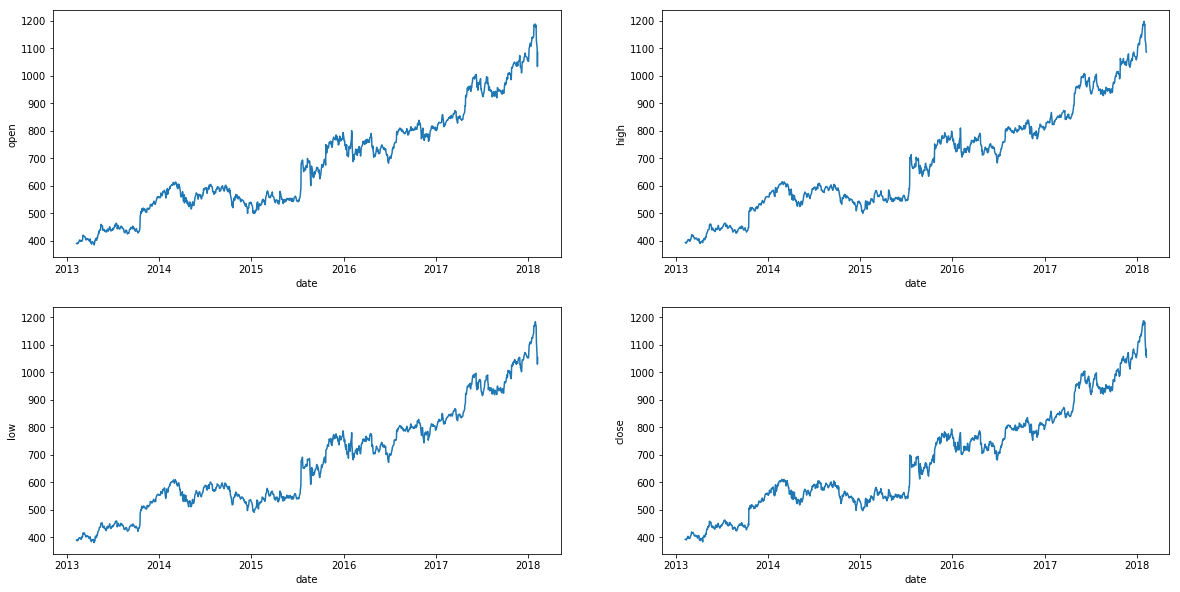

In [12]:
rcParams['figure.figsize'] = 20, 10
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1 = sns.lineplot(x="date", y="open",
                  markers=True, dashes=False, data=company_df)
ax2 = fig.add_subplot(222, sharex=ax1, sharey=ax1)
ax2 = sns.lineplot(x="date", y="high",
                  markers=True, dashes=False, data=company_df)
ax3 = fig.add_subplot(223, sharex=ax1, sharey=ax1)
ax3 = sns.lineplot(x="date", y="low",
                  markers=True, dashes=False, data=company_df)
ax4 = fig.add_subplot(224, sharex=ax1, sharey=ax1)
ax4 = sns.lineplot(x="date", y="close",
                  markers=True, dashes=False, data=company_df)

In [13]:
company_df=company_df[['date','open','high','low','close']]
company_df=company_df.set_index('date')

In [14]:
company_df.head(10)

,open,high,low,close
date,,,,
2013-02-08,390.4551,393.7283,390.1698,393.0777
2013-02-11,389.5892,391.8915,387.2619,391.6012
2013-02-12,391.2659,394.3440,390.0747,390.7403
2013-02-13,390.4551,393.0677,390.3750,391.8214
2013-02-14,390.2549,394.7644,389.2739,394.3039
2013-02-15,394.0937,397.0266,393.9285,396.8414
2013-02-19,398.3930,403.9035,398.0376,403.8284
2013-02-20,403.0527,404.8895,396.2929,396.6262
2013-02-21,399.3990,403.1277,396.0056,398.1628


In [15]:
company_df_close = company_df[['close']]

In [16]:
company_df_close.head()

,close
date,
2013-02-08,393.0777
2013-02-11,391.6012
2013-02-12,390.7403
2013-02-13,391.8214
2013-02-14,394.3039


In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
stocks = scaler.fit_transform(company_df_close)

In [18]:
train = int(len(stocks) * 0.80)
test = len(stocks) - train

In [19]:
print(train, test)

1007 252


In [20]:
train = stocks[0:train]
print(train)

[[0.01210825]
 [0.01027231]
 [0.00920184]
 ...
 [0.54312253]
 [0.54497526]
 [0.55443784]]


In [21]:
test = stocks[len(train) : ]

In [22]:
print(train.shape , test.shape)

(1007, 1) (252, 1)


## Building the RNN

In [23]:
def process_data(data, n_features):
    dataX, dataY = [], []
    for i in range(len(data)-n_features-1):
        a = data[i:(i+n_features), 0]
        dataX.append(a)
        dataY.append(data[i+n_features, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
n_features = 2

trainX, trainY = process_data(train, n_features)
testX, testY = process_data(test, n_features)

In [25]:
print(trainX.shape , trainY.shape , testX.shape , testY.shape)

(1004, 2) (1004,) (249, 2) (249,)


In [26]:
trainX = trainX.reshape(trainX.shape[0] , 1 ,trainX.shape[1])
testX = testX.reshape(testX.shape[0] , 1 ,testX.shape[1])

In [27]:
model = Sequential()
model.add(GRU(256 , input_shape = (1 , n_features) , return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256))
model.add(Dropout(0.4))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

In [28]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 256)            198912    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 740,737
Trainable params: 740,737
Non-trainable params: 0
_________________________________________________________________
None

In [29]:
model.compile(
    loss='mean_squared_error',
    optimizer= 'adam',
    metrics = ['mean_squared_error']
)

In [30]:
model.fit(
    trainX,
    trainY,
    epochs=20,
    batch_size= 128,
    validation_data= (testX,testY)
)

Train on 1004 samples, validate on 249 samples
Epoch 1/20
1004/1004 [==============================] - 4s 4ms/step - loss: 0.0719 - mean_squared_error: 0.0719 - val_loss: 0.1793 - val_mean_squared_error: 0.1793
Epoch 2/20
1004/1004 [==============================] - 1s 585us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 9.3199e-04 - val_mean_squared_error: 9.3199e-04
Epoch 3/20
1004/1004 [==============================] - 1s 613us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0628 - val_mean_squared_error: 0.0628
Epoch 4/20
1004/1004 [==============================] - 1s 602us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 5/20
1004/1004 [==============================] - 1s 590us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 6/20
1004/1004 [==============================] - 1s 611us/step - loss: 0.0020 - mean_squared_error: 0.0020 - v

In [31]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [32]:
model_score(model, trainX, trainY , testX, testY)

Train Score: 0.00016 MSE (0.01 RMSE)
Test Score: 0.00027 MSE (0.02 RMSE)


(0.00016341729247775597, 0.00026560847971954915)

In [33]:
pred = model.predict(testX)
pred = scaler.inverse_transform(pred)
pred[:10]

array([[827.17926],
       [829.73926],
       [834.203  ],
       [836.7656 ],
       [835.8896 ],
       [837.0686 ],
       [841.70355],
       [845.25226],
       [847.6637 ],
       [848.50085]], dtype=float32)

In [34]:
testY = testY.reshape(testY.shape[0] , 1)
testY = scaler.inverse_transform(testY)
testY[:10]

array([[834.85],
       [838.96],
       [840.03],
       [837.32],
       [842.17],
       [846.55],
       [849.27],
       [851.36],
       [851.  ],
       [847.81]])

# Done